<a href="https://colab.research.google.com/github/Rahulgarg95/pytorch_jovian/blob/main/Intel_Image_Classifier_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1W1kH9KsfO_WoOLCXA5IYzCWYfif-cHoB')

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
!pip install opendatasets

# ***Intel Image Classifier***
----


Importing Python libraries and downloading datasets
---





In [ ]:
import os
import torch
import jovian
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import opendatasets as od

In [ ]:
#Downloading dataset from kaggle
od.download('https://www.kaggle.com/puneet6060/intel-image-classification/version/2')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rahulgarg95
Your Kaggle Key: ··········


  6%|▋         | 22.0M/346M [00:00<00:01, 229MB/s]

100%|██████████| 346M/346M [00:03<00:00, 102MB/s] 


In [ ]:
#Checking from base path where our data is stored
base_dir='.'
print(os.listdir(base_dir))

data_path='./intel-image-classification'
print(data_path)

classes=os.listdir(os.path.join(data_path,'seg_train/seg_train/'))
print('Train Classes: ',classes)

print('Test Classes: ',os.listdir(os.path.join(data_path,'seg_test/seg_test/')))

['.config', 'intel-image-classification', 'sample_data']
./intel-image-classification
Train Classes:  ['mountain', 'sea', 'street', 'buildings', 'glacier', 'forest']
Test Classes:  ['mountain', 'sea', 'street', 'buildings', 'glacier', 'forest']


In [ ]:
#Checking no of training files for each class
for tmp in classes:
  x=os.listdir(os.path.join(data_path,'seg_train/seg_train/',tmp))
  print(tmp,':',len(x))

mountain : 2512
sea : 2274
street : 2382
buildings : 2191
glacier : 2404
forest : 2271


In [ ]:
#Checking no of test files for each class
for tmp in classes:
  x=os.listdir(os.path.join(data_path,'seg_test/seg_test/',tmp))
  print(tmp,':',len(x))

mountain : 525
sea : 510
street : 501
buildings : 437
glacier : 553
forest : 474


In [ ]:
project_name='intel_image_classification'

In [ ]:
from PIL import Image

In [ ]:
#Getting an idea of image size
img = Image.open(os.path.join(data_path,'seg_train/seg_train/sea/10016.jpg'))
img.size

(150, 150)

**Data Preparation**
---

----

We will be creating train and validation datasets using ImageFolder class in torchvision library to convert images to tensors.  
But before splitting the data, transformation is required on train data so that training data becomes bit challanging and different pattern are provided to algorithm to handle robust data and increase accuracy.

1.   **Channel-wise data normalization**: *We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.*
2.   **Image Resizing and Randomized Data Augmentations**: *As we identified the images are of size (150 x 150) to make sure all images are of same size we will be resizing all images to same size. In addition to it padding of 4px will be added to the same. In addition to padding, image filling will also be applied.Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.*
3.   **Normalization**: *All values will be converted to range (-1,1) with mean as 0 and std dev as 1*









In [ ]:
#initializing transformer
stats = ((0.4300, 0.4571, 0.4533), (0.2581, 0.2563, 0.2886))

train_tfms=tt.Compose([
  tt.Resize((150,150)),
  tt.RandomCrop(150, padding=4, padding_mode='reflect'),
  tt.RandomHorizontalFlip(),
  tt.ToTensor(),
  tt.Normalize(*stats,inplace=True)
])

valid_tfms = tt.Compose([tt.Resize((150,150)),tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
train_tfms

Compose(
    Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
    RandomCrop(size=(150, 150), padding=4)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.43, 0.4571, 0.4533), std=(0.2581, 0.2563, 0.2886))
)

In [ ]:
valid_tfms

Compose(
    Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=(0.43, 0.4571, 0.4533), std=(0.2581, 0.2563, 0.2886))
)

In [ ]:
# PyTorch datasets
train_ds = ImageFolder(os.path.join(data_path,'seg_train/seg_train/'), train_tfms)
valid_ds = ImageFolder(os.path.join(data_path,'seg_test/seg_test/'), valid_tfms)

In [ ]:
print(train_ds.classes)
print(valid_ds.classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
train_ds

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: ./intel-image-classification/seg_train/seg_train/
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
               RandomCrop(size=(150, 150), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.43, 0.4571, 0.4533), std=(0.2581, 0.2563, 0.2886))
           )

In [ ]:
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  buildings (0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


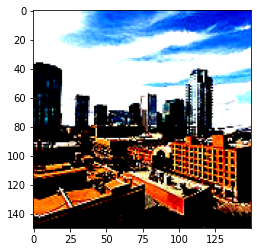

In [ ]:
show_example(*train_ds[1])

Label:  buildings 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(0)


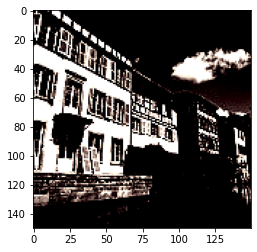

In [ ]:
show_example(*train_ds[150])

In [ ]:
from torch.utils.data import DataLoader

#Creating batches from training data
batch_size=128

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
#As the images are normalized we cannot see colors proper, lets try to denormalise these images
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        plt.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

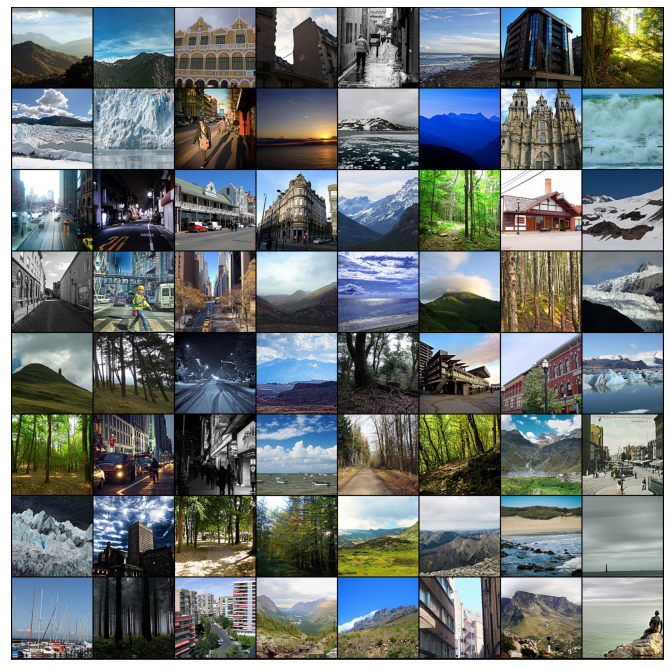

In [ ]:
show_batch(train_dl)

In [ ]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/rahulgarg95/intel-image-classification


'https://jovian.ai/rahulgarg95/intel-image-classification'

**Working with GPU**

---
Defining a set of functions to check if GPU is available and also providing helper functions to easy data loading on GPUs.


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

Defining some common functions in order to calculate loss and implement the same on vaidation dataset.

In [ ]:
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## **ResNet Model**
---
  

**Need For ResNet:**  
*When using a multilayered CNN network/Alexnet as the number of layers are increased, after a certain point error rate starts to increase, this problem is known as Vanishing/Exploding gradient. This causes gradient to either be 0 or too large. Hence as number of layers increases test and train error rate also increases.In order to resolve this issue ResNet model is used.*

**What is ResNet:**  
ResNet stands for Residual Network.It uses a technique of skip connections. This methods skips training froma few layers and connects dorectly to output.


In [ ]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/rahulgarg95/intel-image-classification


'https://jovian.ai/rahulgarg95/intel-image-classification'

In [ ]:
from torchvision import models

class TransferLearning(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(16), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, 6), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
@torch.no_grad()
def evaluate(model, val_dl):
    """ This function evaluated loss and accuracy on validation set """
    model.eval()
    outs = [model.validation_step(x) for x in val_dl]
    return model.validation_epoch_end(outs)

def get_lr(opt):
    """ Returns 'lr' for current epoch """
    for param_group in opt.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    
    """ This is main function which deals with training model on our data """
    torch.cuda.empty_cache()
    history = []
    
    opt = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs,
                                               steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        
        for batch in train_dl:
            # Training step
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            opt.step()
            opt.zero_grad()
            
            lrs.append(get_lr(opt))
            sched.step()
            
        # Validation step
        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch+1, result)
        history.append(result)
        
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.1708984375, 'val_loss': 1.7895686626434326}]

We got around 18% validation accuracy with randomly initialised weights.

In [ ]:
#Setting initial metric data
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [1], last_lr: 0.00277, train_loss: 0.9677, val_loss: 0.8344, val_acc: 0.7127
Epoch [2], last_lr: 0.00759, train_loss: 0.7373, val_loss: 1.1222, val_acc: 0.6207
Epoch [3], last_lr: 0.01000, train_loss: 0.7407, val_loss: 1.0127, val_acc: 0.6861
Epoch [4], last_lr: 0.00950, train_loss: 0.6028, val_loss: 0.6105, val_acc: 0.7768
Epoch [5], last_lr: 0.00812, train_loss: 0.4935, val_loss: 0.3855, val_acc: 0.8556
Epoch [6], last_lr: 0.00611, train_loss: 0.4168, val_loss: 0.4425, val_acc: 0.8276
Epoch [7], last_lr: 0.00389, train_loss: 0.3760, val_loss: 0.4121, val_acc: 0.8512
Epoch [8], last_lr: 0.00188, train_loss: 0.3135, val_loss: 0.3213, val_acc: 0.8881
Epoch [9], last_lr: 0.00050, train_loss: 0.2627, val_loss: 0.2832, val_acc: 0.8971
Epoch [10], last_lr: 0.00000, train_loss: 0.2352, val_loss: 0.2698, val_acc: 0.9015
CPU times: user 7min 5s, sys: 6min 17s, total: 13min 22s
Wall time: 13min 57s


**Got an accuracy of around 90% in 14 minutes and after 10 ephocs**

In [ ]:
train_time='13:57'

# Tranfer Learning

---

Training a new model on already trained model, in order to reduce training time and utilise the learnings.



In [ ]:
model2 = TransferLearning(6)
to_device(model2, device);

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
thistory = [evaluate(model2, valid_dl)]
thistory

[{'val_acc': 0.12768907845020294, 'val_loss': 2.1119227409362793}]

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
thistory += fit_one_cycle(epochs, max_lr, model2, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [1], last_lr: 0.00277, train_loss: 0.4107, val_loss: 1.3302, val_acc: 0.6278
Epoch [2], last_lr: 0.00759, train_loss: 0.4940, val_loss: 1.5419, val_acc: 0.5802
Epoch [3], last_lr: 0.01000, train_loss: 0.4720, val_loss: 0.8088, val_acc: 0.7247
Epoch [4], last_lr: 0.00950, train_loss: 0.5243, val_loss: 0.9316, val_acc: 0.7432
Epoch [5], last_lr: 0.00812, train_loss: 0.4671, val_loss: 0.5614, val_acc: 0.7915
Epoch [6], last_lr: 0.00611, train_loss: 0.3525, val_loss: 0.4322, val_acc: 0.8501
Epoch [7], last_lr: 0.00389, train_loss: 0.3170, val_loss: 0.3384, val_acc: 0.8805
Epoch [8], last_lr: 0.00188, train_loss: 0.2558, val_loss: 0.2882, val_acc: 0.8991
Epoch [9], last_lr: 0.00050, train_loss: 0.2167, val_loss: 0.2492, val_acc: 0.9127
Epoch [10], last_lr: 0.00000, train_loss: 0.1831, val_loss: 0.2287, val_acc: 0.9211
CPU times: user 2min 1s, sys: 54.5 s, total: 2min 55s
Wall time: 5min 12s


***Using Transfer Learning Model acheived an accuracy of 92% in 5 minutes and 10 ephocs***

In [ ]:
tranf_train_time='5:12'

## Plotting accuracy and Validation Accuracy

---





In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

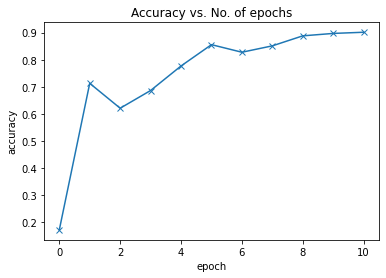

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

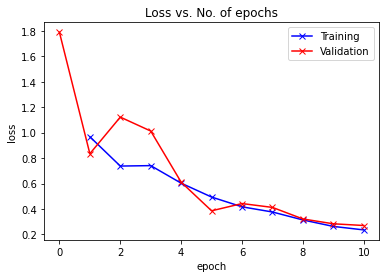

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

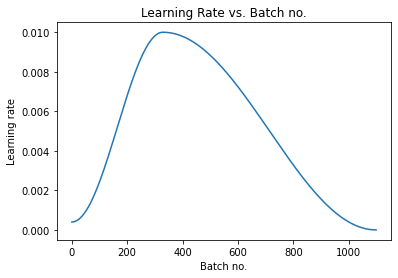

In [ ]:
plot_lrs(history)


In [ ]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/rahulgarg95/intel-image-classification


'https://jovian.ai/rahulgarg95/intel-image-classification'

# Testing with Individual images

In [ ]:
def denormalize_image(img, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return img * stds + means

def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return train_ds.classes[preds[0].item()]

Label: buildings , Predicted: buildings


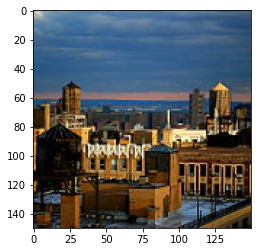

In [ ]:
img, label = valid_ds[10]
plt.imshow(denormalize_image(img, *stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: glacier , Predicted: glacier


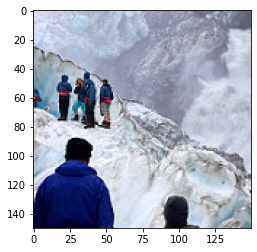

In [ ]:
img, label = valid_ds[1000]
plt.imshow(denormalize_image(img, *stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: forest , Predicted: forest


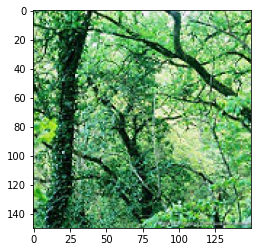

In [ ]:
img, label = valid_ds[789]
plt.imshow(denormalize_image(img, *stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: street , Predicted: buildings


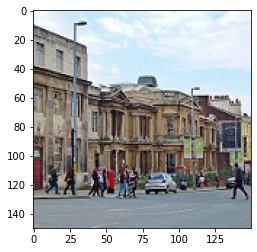

In [ ]:
#Image where model fails, difficult to analyse as buildings and street bith are present
img, label = valid_ds[2700]
plt.imshow(denormalize_image(img, *stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: street , Predicted: street


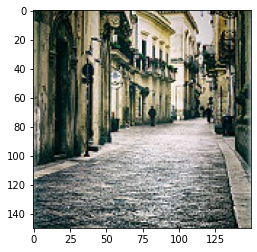

In [ ]:
img, label = valid_ds[2750]
plt.imshow(denormalize_image(img, *stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
torch.save(model.state_dict(), 'intel-img-resnet9.pth')

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [ ]:
jovian.commit(project=project_name, environment=None, outputs=['intel-img-resnet9.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/rahulgarg95/intel-image-classification


'https://jovian.ai/rahulgarg95/intel-image-classification'

In [ ]:
#Transfer Learning Models
torch.save(model2.state_dict(), 'transfer-intel-img-resnet9.pth')

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet34', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(val_loss=thistory[-1]['val_loss'], 
                   val_acc=thistory[-1]['val_acc'],
                   train_loss=thistory[-1]['train_loss'],
                   time=tranf_train_time)

[jovian] Metrics logged.
